In [1]:
from ticker_reader import ReadTickers
import pandas as pd
from matplotlib import pyplot as plt
ticker_class = ReadTickers()

In [2]:
ticker_class.strategy(9,9)

In [3]:
aligned_tickers = ticker_class.latest_start()
nvda_df = aligned_tickers['NVDA']
amd_df = aligned_tickers['AMD']
socks_df = aligned_tickers['SOXX']

Go long Nvidia if its 10-day return z-score > AMD & TSMC

In [4]:
long_df = nvda_df[(nvda_df['zscore'] > amd_df['zscore']) & 
                  nvda_df['R_return'] > socks_df['R_return'] * 1.05]

### let's say we have 100k 

#### what would be the benefit to doing this strategy vs depositing blindly and periodically?

we have.... 500 per month to deposit 

## strat1: "risk free" 
we deposit at the end of the month regardless 

## strat2:"timing the market"
we can deposit a maximum of 500 per month 
if during a month no signal occurs, the money carries over to the next month

given a signal, deposit at open on the following day

In [5]:
dca_cash = 0
dca_nvda_shares = 0
dca_balance_history = []

# Get the last trading day of each month
month_ends = nvda_df.resample('ME').last()

for date in month_ends.index:
    # Find the next trading day after month end
    next_idx = nvda_df.index.searchsorted(date, side='right')
    if next_idx < len(nvda_df):
        next_day = nvda_df.index[next_idx]
        open_price = nvda_df.loc[next_day, 'Open']

        shares_bought = 500 / open_price
        dca_nvda_shares += shares_bought
        dca_cash += 500  # track total deposited
        dca_balance_history.append((next_day, dca_cash, dca_nvda_shares))

dca_portfolio = pd.DataFrame(dca_balance_history, columns=["Date", "Deposited", "Shares"])
dca_portfolio["Date"] = pd.to_datetime(dca_portfolio["Date"])
dca_portfolio.set_index("Date", inplace=True)

strat2

In [6]:
signal_cash_pool = 0
signal_nvda_shares = 0
signal_balance_history = []
signal_deposited = 0

# Group signal rows by calendar month
grouped = long_df.groupby(pd.Grouper(freq='ME'))

for month, signal_rows in grouped:

    # Add $500 to pool for this month
    signal_cash_pool += 500

    # If no signal this month, skip (keep cash)
    if signal_rows.empty:
        continue

    # Get the first signal day in the month
    signal_day = signal_rows.index[0]

    # Get next trading day in nvda_df after signal_day
    next_idx = nvda_df.index.searchsorted(signal_day, side='right')

    if next_idx >= len(nvda_df):
        continue  # no valid trading days left

    buy_day = nvda_df.index[next_idx]
    open_price = nvda_df.loc[buy_day, 'Open']

    # Buy NVDA using all available cash
    shares_bought = signal_cash_pool / open_price
    signal_deposited += signal_cash_pool
    signal_nvda_shares += shares_bought

    signal_balance_history.append((buy_day, signal_deposited, signal_nvda_shares))

    # Reset pool after buying
    signal_cash_pool = 0

# Final result as DataFrame
signal_portfolio = pd.DataFrame(signal_balance_history, columns=["Date", "Deposited", "Shares"])
signal_portfolio["Date"] = pd.to_datetime(signal_portfolio["Date"])
signal_portfolio.set_index("Date", inplace=True)


In [7]:
print(dca_portfolio)

            Deposited         Shares
Date                                
2007-04-02        500    1139.589839
2007-05-01       1000    2116.526687
2007-06-01       1500    3050.515447
2007-07-02       2000    3831.366183
2007-08-01       2500    4556.811835
...               ...            ...
2025-04-01     108500  159601.182964
2025-05-01     109000  159605.604920
2025-06-02     109500  159609.295485
2025-07-01     110000  159612.494666
2025-08-01     110500  159615.366744

[221 rows x 2 columns]


In [8]:
print(signal_portfolio)

            Deposited         Shares
Date                                
2007-03-30        500    1124.704076
2007-04-03       1000    2262.707175
2007-05-02       1500    3241.984055
2007-06-04       2000    4188.674365
2007-07-03       2500    4949.548896
...               ...            ...
2025-04-02     109000  161066.820896
2025-05-02     109500  161071.200251
2025-06-03     110000  161074.803326
2025-07-02     110500  161078.071727
2025-08-04     111000  161080.926260

[222 rows x 2 columns]


Text(0.5, 0, 'time')

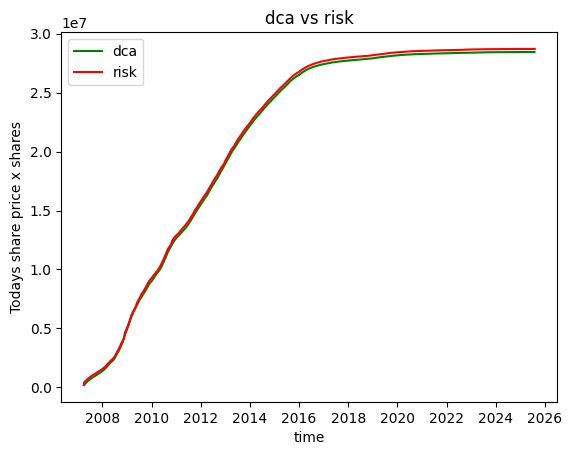

In [9]:
current_price = nvda_df.loc[nvda_df.index[len(nvda_df)-1]]['Close']
plt.plot(dca_portfolio.index,dca_portfolio['Shares']*current_price,
         color='green',
         label='dca')
plt.plot(signal_portfolio.index,signal_portfolio['Shares']*current_price,
         color='red',
         label='risk')
plt.title('dca vs risk')
plt.legend()
plt.ylabel('Todays share price x shares')
plt.xlabel('time')

I think the signal is firing too often, it would be nice to see it not fire once a month or something

In [10]:
# Step 1: Compute value over time using today's price
dca_value = dca_portfolio["Shares"] * current_price
signal_value = signal_portfolio["Shares"] * current_price

# Step 2: Convert to time series
dca_series = dca_value.resample("ME").last().ffill()
signal_series = signal_value.resample("ME").last().ffill()

# Step 3: Compute monthly returns
dca_returns = dca_series.pct_change().dropna()
signal_returns = signal_series.pct_change().dropna()

# Step 4: Compute Sharpe ratios (monthly → annualized)
def sharpe_ratio(returns, periods_per_year=12):
    return (returns.mean() / returns.std()) * (periods_per_year ** 0.5)

dca_sharpe = sharpe_ratio(dca_returns)
signal_sharpe = sharpe_ratio(signal_returns)

print(f"DCA Sharpe Ratio: {dca_sharpe:.3f}")
print(f"Signal Sharpe Ratio: {signal_sharpe:.3f}")


DCA Sharpe Ratio: 1.167
Signal Sharpe Ratio: 1.067


In [11]:
# Ensure datetime index for lookup
dca_portfolio.index = pd.to_datetime(dca_portfolio.index)
signal_portfolio.index = pd.to_datetime(signal_portfolio.index)

# Use historical close price per date
dca_value = dca_portfolio["Shares"] * nvda_df["Close"].reindex(dca_portfolio.index)
signal_value = signal_portfolio["Shares"] * nvda_df["Close"].reindex(signal_portfolio.index)

def compute_max_drawdown(series):
    # tracks highest value in series
    cumulative_max = series.cummax()

    # compute percentage change from highest point, where highest point is always below the 
    # currently tracked series point technically
    drawdown = (series - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()  # This is a negative number
    
    return max_drawdown
dca_max_dd = compute_max_drawdown(dca_value)
signal_max_dd = compute_max_drawdown(signal_value)

print(f"DCA Max Drawdown: {dca_max_dd:.2%}")
print(f"Signal Max Drawdown: {signal_max_dd:.2%}")


DCA Max Drawdown: -60.10%
Signal Max Drawdown: -58.92%


In [14]:
soxx_value_history = []
soxx_cumulative_shares = 0
total_deposited = 0

month_ends = nvda_df.resample('ME').last().index

for date in month_ends:
    next_idx = socks_df.index.searchsorted(date, side='right')
    if next_idx >= len(socks_df): continue
    buy_day = socks_df.index[next_idx]
    open_price = socks_df.loc[buy_day, 'Open']

    shares_bought = 500 / open_price
    soxx_cumulative_shares += shares_bought
    total_deposited += 500

    soxx_value = soxx_cumulative_shares * socks_df.loc[buy_day, 'Close']
    soxx_value_history.append((buy_day, total_deposited, soxx_value))

soxx_portfolio = pd.DataFrame(soxx_value_history, columns=["Date", "Deposited", "Value"])
soxx_portfolio.set_index("Date", inplace=True)

# Normalize like DCA strategy
soxx_equity = soxx_portfolio["Value"] / soxx_portfolio["Value"].iloc[0]


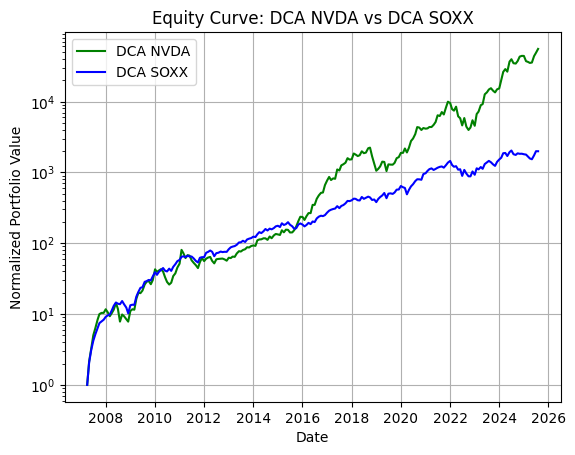

In [15]:
dca_value = dca_portfolio["Shares"] * nvda_df["Close"].reindex(dca_portfolio.index)
dca_equity = dca_value / dca_value.iloc[0]

plt.plot(dca_equity.index, dca_equity, label="DCA NVDA", color="green")
plt.plot(soxx_equity.index, soxx_equity, label="DCA SOXX", color="blue")
plt.title("Equity Curve: DCA NVDA vs DCA SOXX")
plt.xlabel("Date")
plt.yscale('log')
plt.ylabel("Normalized Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
